# Data Analysis

after removing duplicates, outliers and handling missing data ; analysis

First part very similar to previous data exploration

## Imports and load data

In [94]:
# Import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import shapiro, kruskal, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [7]:
data = pd.read_csv("Clean_data.csv", index_col=0)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10997 entries, 0 to 10996
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                10997 non-null  int64  
 1   Locality                          10997 non-null  object 
 2   Type of property                  10997 non-null  object 
 3   Subtype of property               10997 non-null  object 
 4   Type of sale                      10997 non-null  object 
 5   Fully equipped kitchen            10997 non-null  object 
 6   Fireplace                         10997 non-null  object 
 7   Terrace                           10997 non-null  object 
 8   Garden                            10997 non-null  object 
 9   Garden area                       10997 non-null  float64
 10  Surface of the land               10997 non-null  float64
 11  Surface area of the plot of land  10997 non-null  float64
 12  Swimming 

## Fix data types

In [11]:
data['Locality'] = data['Locality'].astype('str')
data['Fully equipped kitchen'] = data['Fully equipped kitchen'].astype('str')
data['Fireplace'] = data['Fireplace'].astype('str')
data['Terrace'] = data['Terrace'].astype('str')
data['Garden'] = data['Garden'].astype('str')
data['Swimming pool'] = data['Swimming pool'].astype('str')
data['Furnished'] = data['Furnished'].astype('str')
data['Number of rooms'] = data['Number of rooms'].astype('int64')
data['Number of facades'] = data['Number of facades'].astype('int64')

## Distributions of numerical data

In [39]:
# Get numerical continuous columns

numerical_columns = []
for column in data.columns:
    if column in ['id', 'Surface of the land']:
        pass
    else:
        if data[column].dtype in ['float64', 'int64']:
            numerical_columns.append(column)

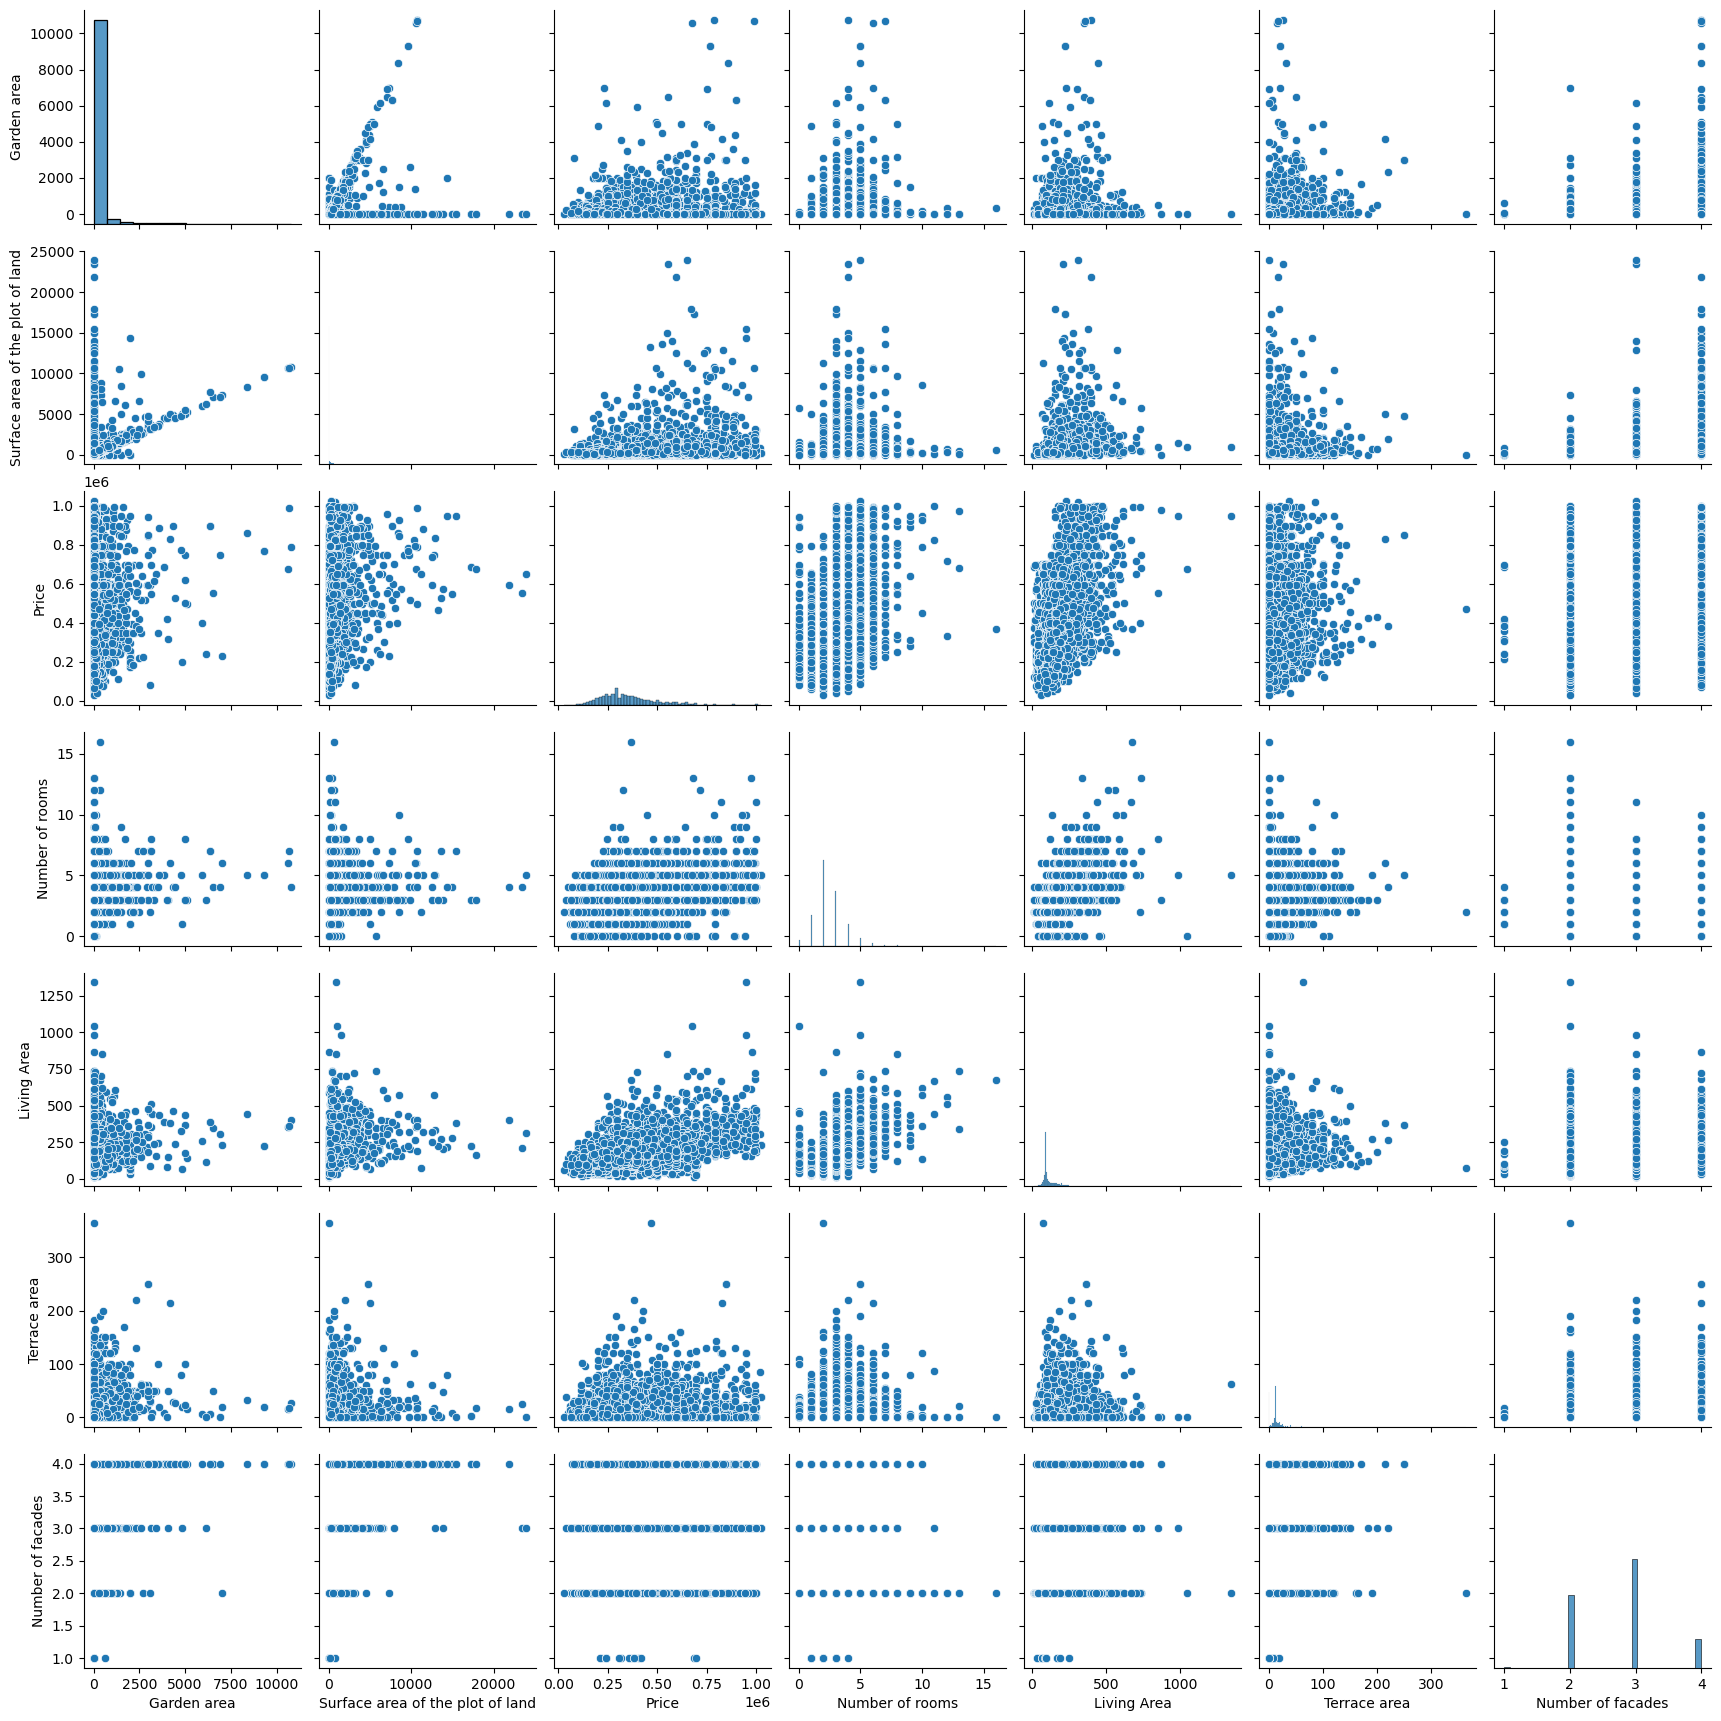

In [41]:
# Distributions and pairplots

sns.pairplot(data= data, vars= numerical_columns)
plt.show()

In [42]:
# Check normality

for variable in numerical_columns:
    print(f"Test for {variable} returns {shapiro(data[variable])}")

Test for Garden area returns ShapiroResult(statistic=0.2032958666687782, pvalue=5.455489835414013e-112)
Test for Surface area of the plot of land returns ShapiroResult(statistic=0.275222497636721, pvalue=1.6011486728890444e-109)
Test for Price returns ShapiroResult(statistic=0.9220306016011196, pvalue=1.838546882347722e-59)
Test for Number of rooms returns ShapiroResult(statistic=0.8800579742852546, pvalue=6.345265285614841e-68)
Test for Living Area returns ShapiroResult(statistic=0.6980619195970579, pvalue=5.183751901081592e-88)
Test for Terrace area returns ShapiroResult(statistic=0.6281208438590045, pvalue=6.509524156238942e-93)
Test for Number of facades returns ShapiroResult(statistic=0.7922757201579189, pvalue=1.4891813888294324e-79)


c:\Users\kvnpo\anaconda3\envs\ImmoEliza\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10997.
  res = hypotest_fun_out(*samples, **kwds)


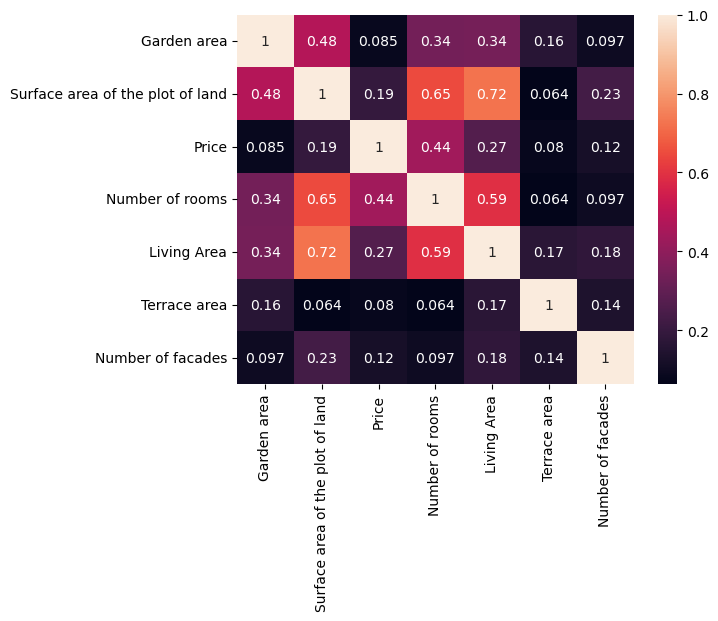

In [43]:
# Spearman's rho and heatmap

correlations = data[numerical_columns].corr(method= 'spearman')
sns.heatmap(correlations, annot= True)
plt.show()

1. None of the variables are normally distributed, many show high skewness
2. Surface of the land has to be excluded (same as Garden area)
3. Correlations between predictors, check VIF - multicollinearity
4. Price most affected by Number of rooms, living area and Surface of the plot
5. Subdividing houses and apartments returns similar results (order importance slightly different), still no normal data

In [63]:
houses = data[data['Type of property'] == 'HOUSE']

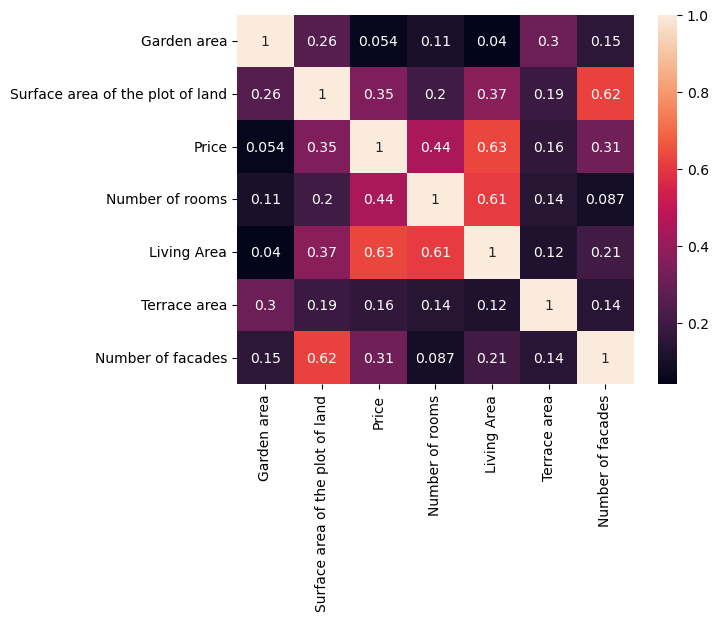

In [ ]:
correlations = houses[numerical_columns].corr(method= 'spearman')
sns.heatmap(correlations, annot= True)
plt.show()

In [54]:
# Check VIF 

numerical_predictors = ['Garden area',
 'Surface area of the plot of land',
 'Number of rooms',
 'Living Area',
 'Terrace area',
 'Number of facades']
X = data[numerical_predictors]
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

                            Feature       VIF
0                       Garden area  1.346285
1  Surface area of the plot of land  1.492580
2                   Number of rooms  8.031621
3                       Living Area  7.437804
4                      Terrace area  1.913055
5                 Number of facades  5.196131


1. Relatively high VIF for two variables strongly associated to the response, need to be dealt with
2. Quite low for others

## Dimension reduction of numerical data

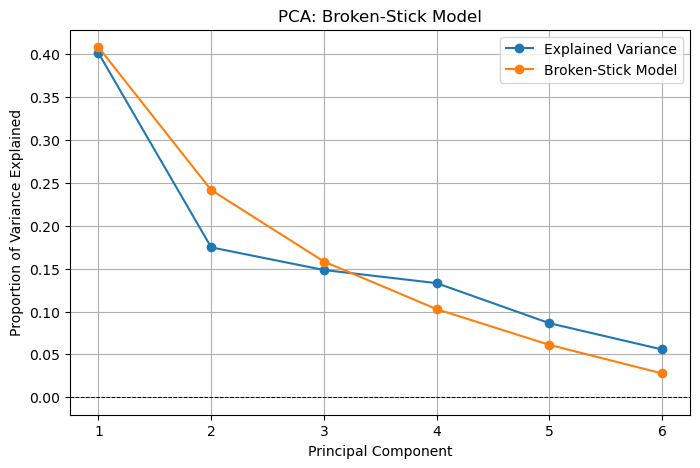

In [95]:
# Standardize data

numerical_data = data[numerical_predictors]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Perform PCA

pca = PCA()
pca.fit(scaled_data)

# Broken stick

def broken_stick(n_components, total_components):
    """Calculate broken-stick model values for n_components."""
    return [np.sum([1 / k for k in range(i, total_components + 1)]) / total_components for i in range(1, n_components + 1)]

n_components = len(pca.explained_variance_ratio_)
broken_stick_values = broken_stick(n_components, n_components)

# Step 5: Create a DataFrame for Comparison
explained_variance = pca.explained_variance_ratio_
comparison_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(n_components)],
    'Explained Variance': explained_variance,
    'Broken-Stick Value': broken_stick_values
})

# Step 6: Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), explained_variance, 'o-', label='Explained Variance')
plt.plot(range(1, n_components + 1), broken_stick_values, 'o-', label='Broken-Stick Model')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('PCA: Broken-Stick Model')
plt.legend()
plt.grid()
plt.show()


In [99]:
pca = PCA()
pca.fit(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_

explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': np.cumsum(explained_variance_ratio)
})

explained_variance_df

,Principal Component,Explained Variance Ratio,Cumulative Explained Variance
0,PC1,0.401534,0.401534
1,PC2,0.174855,0.576389
2,PC3,0.148441,0.724830
3,PC4,0.133085,0.857916
4,PC5,0.086374,0.944290
5,PC6,0.055710,1.000000


In [100]:
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

pca_scores = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

In [104]:
correlations = pd.DataFrame(
    {f'PC{i+1}': [np.corrcoef(scaled_data[:, j], pca_scores[f'PC{i+1}'])[0, 1] 
                  for j in range(scaled_data.shape[1])] 
     for i in range(principal_components.shape[1])},
    index=data[numerical_predictors].columns
)

In [105]:
correlations

,PC1,PC2,PC3,PC4,PC5,PC6
Garden area,0.621815,-0.384681,-0.041343,-0.545399,-0.403805,0.056016
Surface area of the plot of land,0.728107,-0.212551,-0.270264,-0.230067,0.535922,-0.107219
Number of rooms,0.710375,0.560111,-0.000514,0.091000,-0.187920,-0.371548
Living Area,0.779421,0.437222,-0.026742,0.141652,0.021133,0.424396
Terrace area,0.419799,-0.236579,0.863672,0.101321,0.104439,-0.026401
Number of facades,0.451716,-0.543246,-0.263155,0.639929,-0.145972,-0.027733


## Check for associations of categorical variables with price

In [ ]:
# Separate categorical columns

categorical_columns = ['Locality',
 'Type of property',
 'Subtype of property',
 'State of the building']

binary_columns =  ['Fully equipped kitchen',
 'Fireplace',
 'Terrace',
 'Garden',
 'Swimming pool',
 'Compound Listing',
 'Furnished']

In [90]:
categorical_columns

['Locality',
 'Type of property',
 'Subtype of property',
 'State of the building']

In [ ]:
# Kruskal-Wallis test for categoricals

results = []

predictor_data = data[categorical_columns]
response_data = data[['Price']]

for cat_col in predictor_data.columns:
    # Get unique categories for this categorical variable
    categories = data[cat_col].unique()

    # Group the 'Price' data by the categorical variable
    groups = [data[data[cat_col] == category]['Price'] for category in categories]
    stat, p_value = kruskal(*groups)
    
    if p_value < 0.05:
        Difference = "Significant"
    else:
        Difference = "Not Significant"
    results.append({
        "Categorical Variable": cat_col,
        "H-statistic": stat,
        "P-value": p_value,
        "Difference": Difference
    })

results_df = pd.DataFrame(results)
print(results_df)
    


     Categorical Variable  U-statistic       P-value
0  Fully equipped kitchen   12875318.0  5.938693e-01
1               Fireplace    1034645.5  7.870536e-26
2                 Terrace   12844155.0  1.278551e-49
3                  Garden   11246655.5  3.611749e-14
4           Swimming pool     393669.0  5.298736e-31
5        Compound Listing   13710809.5  2.175385e-04
6               Furnished    1141280.5  6.716385e-01


               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
    group1         group2       meandiff   p-adj     lower        upper    reject
---------------------------------------------------------------------------------
        AS_NEW           GOOD  -48170.4654    0.0  -59920.7873 -36420.1436   True
        AS_NEW JUST_RENOVATED  -53646.0222    0.0  -75844.2171 -31447.8273   True
        AS_NEW  TO_BE_DONE_UP  -87912.3064    0.0 -107481.6875 -68342.9254   True
        AS_NEW    TO_RENOVATE -105519.8145    0.0 -124061.9743 -86977.6548   True
        AS_NEW     TO_RESTORE -127778.9395 0.0005 -217544.6505 -38013.2286   True
        AS_NEW        UNKNOWN  -66083.4249    0.0  -78862.1556 -53304.6943   True
          GOOD JUST_RENOVATED   -5475.5568 0.9892  -26957.2829  16006.1693  False
          GOOD  TO_BE_DONE_UP   -39741.841    0.0  -58494.5841 -20989.0979   True
          GOOD    TO_RENOVATE  -57349.3491    0.0  -75027.4822 -39671.2161   True
          GOOD  

C:\Users\kvnpo\AppData\Local\Temp\ipykernel_17900\2688613726.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='State of the building', y='Price', data=data, palette='Set2')


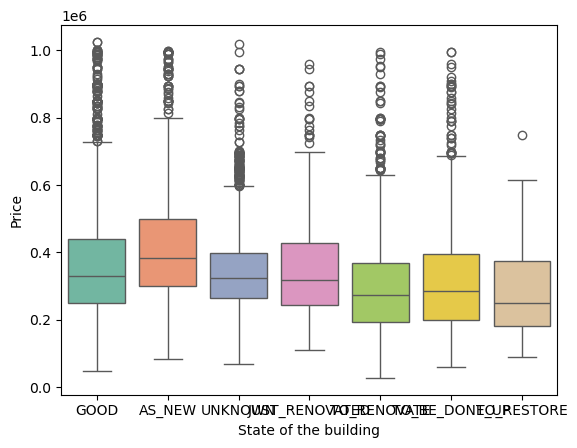

In [86]:
# All variables significant - perform post-hoc tests

tukey_results = pairwise_tukeyhsd(data['Price'], data['State of the building'], alpha= 0.05)
print(tukey_results)
sns.boxplot(x='State of the building', y='Price', data=data, palette='Set2')

# Add labels and title
#plt.xlabel('Category')
#plt.ylabel('Value')
#plt.title('Boxplot of Values by Category')

# Show the plot
plt.show()

# No clear visible difference in price between houses and apartments
# Houses have greater variance in price
# Both groups have outliers

In [93]:
# Mann-Whitney-U test for categoricals

results = []

predictor_data = data[binary_columns]
response_data = data[['Price']]

for cat_col in predictor_data.columns:
    # Get unique categories for this categorical variable
    categories = data[cat_col].unique()

    # Group the 'Price' data by the categorical variable
    groups = [data[data[cat_col] == category]['Price'] for category in categories]
    result = kruskal(*groups)

    results.append({
        "Categorical Variable": cat_col,
        "U-statistic": result.statistic,
        "P-value": result.pvalue,
    })

results_df = pd.DataFrame(results)
print(results_df)

     Categorical Variable  U-statistic       P-value
0  Fully equipped kitchen     0.284346  5.938670e-01
1               Fireplace   110.434644  7.869766e-26
2                 Terrace   219.310900  1.278483e-49
3                  Garden    57.369500  3.611648e-14
4           Swimming pool   134.061106  5.297954e-31
5        Compound Listing    13.673209  2.175359e-04
6               Furnished     0.179701  6.716305e-01
